####  Submitted By: Lior Kricheli, Eliran Malka and Itamar Yacoby

## Final Project in Deep Learning

### Lecturer - Dr. Jonathan Rubin

#### Holon Institute of Technology - 21.06.2021

###### This project uses the colorectal histology dataset by tensorflow and aims to train a ConvNet model to classify tumorous cells in a biopsy test


In [6]:
pip install patchify

In [7]:
# TensorFlow and tf.keras
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tifffile as tiff
from sklearn.metrics import confusion_matrix
from seaborn import heatmap 
from sklearn.manifold import TSNE
from patchify import patchify

print(tf.__version__)

2.5.0


# IMPORTANT!
## Choose bellow the right cell to run (Colab or PC)

In [8]:
#USE THIS CELL TO RUN ON COLAB

!git clone https://github.com/ithamar000/DeepLearningFinalProject.git

pathTrain = '/content/DeepLearningFinalProject/archive/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/train'
pathTest = '/content/DeepLearningFinalProject/archive/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/validation'

Cloning into 'DeepLearningFinalProject'...
remote: Enumerating objects: 5106, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 5106 (delta 9), reused 17 (delta 6), pack-reused 5084
Receiving objects: 100% (5106/5106), 1001.90 MiB | 37.80 MiB/s, done.
Resolving deltas: 100% (176/176), done.
Checking out files: 100% (5022/5022), done.


In [9]:
# #USE THIS CELL TO RUN ON PC

# pathTrain = 'archive\\Kather_texture_2016_image_tiles_5000\\Kather_texture_2016_image_tiles_5000\\train'
# pathTest = 'archive\\Kather_texture_2016_image_tiles_5000\\Kather_texture_2016_image_tiles_5000\\validation'

# Part 1: Function Defenitions

#### plot_results(history)

plot the accuracy and loss.

##### history - contains the accuracy and loss of a trained model

In [10]:
def plot_results(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'],':r')
    plt.plot(history.history['val_loss'],'.-r')
    plt.title('Loss',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'],':b')
    plt.plot(history.history['val_accuracy'],'b')
    plt.ylim([0, 1])
    plt.title('Accuracy',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.grid()

#### plot_confusion_matrix(model, test_generator)
plot a confusion matrix

##### model - The trained model
##### test_generator - the generator used by the model

In [11]:
# Function to plot a confusion matrix

def plot_confusion_matrix(model, test_generator):
    true_labels = test_generator.classes
    predictions = model.predict(test_generator)
    y_true = true_labels
    y_pred = np.array([np.argmax(x) for x in predictions])
    cm = confusion_matrix(y_true, y_pred)
    CM = cm / cm.sum(axis=1)


    plt.figure(figsize=(10,8))
    heatmap(CM,cmap='Blues',annot=True, fmt='.2%')
    plt.xlabel('Predicted label', fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.show()

#### visualize_labelled_data(model, test_generator)

Function to plot a visualization of labelled-data distribution in 2D (Using t-SNE) 

##### model - The trained model
##### test_generator - the generator used by the model

In [12]:
# Function to plot a visualization of labelled-data distribution in 2D (Using t-SNE) 

def visualize_labelled_data(model, test_generator):
    features_extractor = keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
    features = features_extractor.predict(test_generator)

    X_embedded = TSNE(n_components=2).fit_transform(features)
    y = test_generator.classes

    plt.figure(figsize=(10,8))
    plt.scatter(X_embedded[:,0],X_embedded[:,1],80,y, 
                cmap='tab20', alpha=0.7, edgecolors='k')
    plt.colorbar()
    plt.show()

#### get_data_gen(data_augmentation)

Returns data generator

if data_augmentation == True -> applying data augmentation to images

else the images remains in their original condition

##### data_augmentation - boolean to decide if data augmentation is wanted


In [13]:

def get_data_gen(data_augmentation):
    
    my_batch_size = 32  
    
    if(data_augmentation):
        dataGen = ImageDataGenerator(shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     rotation_range=30,
                                     width_shift_range=2,)
        
        train_generator = dataGen.flow_from_directory(pathTrain,
                                                      batch_size=my_batch_size, 
                                                      class_mode='categorical')

        dataGenTest = ImageDataGenerator()
        test_generator = dataGenTest.flow_from_directory(pathTest,                                              
                                                     batch_size=my_batch_size, 
                                                     class_mode='categorical', 
                                                     shuffle=False)
    else:
        dataGen = ImageDataGenerator()
        train_generator = dataGen.flow_from_directory(pathTrain,
                                                      batch_size=my_batch_size, 
                                                      class_mode='categorical')

        dataGenTest = ImageDataGenerator()
        test_generator = dataGenTest.flow_from_directory(pathTest,                                              
                                                     batch_size=my_batch_size, 
                                                     class_mode='categorical', 
                                                     shuffle=False)
    return train_generator,test_generator

#### get_big_model()

Returns a ConvNet Model containing mulitple Conv Layers, Dropout, and Max Pooling



In [14]:
def get_big_model():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (150, 150, 3)))
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3)) 

    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3)) 

    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(8, activation = 'softmax'))
    
    return model


#### get_small_model()

Returns a small ConvNet model containing some Conv Layers and Max Pooling without Dropout



In [15]:
def get_small_model():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (150, 150, 3)))
    model.add(MaxPooling2D(pool_size = 3)) 
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(MaxPooling2D(pool_size = 3)) 
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(8, activation = 'softmax'))
    
    return model

# Part 2: Training Multiple Models

#### In this part we will train three different models with different complexity
#### In the table below you can see the results we achieved with each model

## Summary of results:

<table>
  <tr>
    <th>Model</th>
    <th>#parameters</th>
    <th>epochs</th>
    <th>train accuracy</th>
    <th>test accuracy</th>
  </tr>
    
  <!-- copy this block once for every model you tested -->  
  <tr> 
    <td>> Simple ConvNet </td>   <!-- Model -->
    <td>> 24,104 </td> <!-- Parameters -->
    <td>> 75 </td> <!-- epochs -->
    <td>> 0.9680 </td> <!-- train -->
    <td>> 0.8226 </td> <!--  test -->
  </tr>

  <tr> 
    <td>> Simple ConvNet Data Augmentation</td>   <!-- model -->
    <td>> 24,104 </td> <!-- parameters -->
    <td>> 75 </td> <!-- epochs -->
    <td>> 0.8932 </td> <!-- train -->
    <th>> 0.8609 </th> <!-- test -->
  </tr>

  <tr> 
    <td>> Bigger ConvNet Data Augmentation + Adam optimizer</td>   <!-- model -->
    <td>> 639,240 </td> <!-- parameters -->
    <td>> 75 </td> <!-- epochs -->
    <th>> 0.9127 </th> <!-- train -->
    <td>> 0.8327 </td> <!-- test -->
  </tr>
    
</table>




In [16]:
#initializing  two sets of data generator, one with augmentaion and one without.

train_generator_original ,test_generator_original = get_data_gen(False)
train_generator_aug, test_generator_aug = get_data_gen(True)


Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.
Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


In [17]:
small_model = get_small_model()
small_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
global_max_pooling2d (Global (None, 64)                0

In [18]:
small_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 75

small_model_history = small_model.fit(train_generator_original,
                                      steps_per_epoch=train_generator_original.samples/train_generator_original.batch_size, 
                                      validation_data=test_generator_original,
                                      epochs=epochs, batch_size=20, verbose=1)

Epoch 1/75
140/140 [==============================] - 41s 66ms/step - loss: 2.5527 - accuracy: 0.4381 - val_loss: 0.9334 - val_accuracy: 0.6573
Epoch 2/75
140/140 [==============================] - 9s 64ms/step - loss: 1.0560 - accuracy: 0.5917 - val_loss: 0.7321 - val_accuracy: 0.7278
Epoch 3/75
140/140 [==============================] - 9s 63ms/step - loss: 0.8140 - accuracy: 0.6876 - val_loss: 0.6475 - val_accuracy: 0.7702
Epoch 4/75
140/140 [==============================] - 9s 64ms/step - loss: 0.6973 - accuracy: 0.7318 - val_loss: 0.6039 - val_accuracy: 0.7823
Epoch 5/75
140/140 [==============================] - 9s 62ms/step - loss: 0.6149 - accuracy: 0.7649 - val_loss: 0.6587 - val_accuracy: 0.7641
Epoch 6/75
140/140 [==============================] - 9s 63ms/step - loss: 0.5450 - accuracy: 0.8004 - val_loss: 0.7754 - val_accuracy: 0.7399
Epoch 7/75
140/140 [==============================] - 9s 62ms/step - loss: 0.5277 - accuracy: 0.8053 - val_loss: 0.4691 - val_accuracy: 0.814

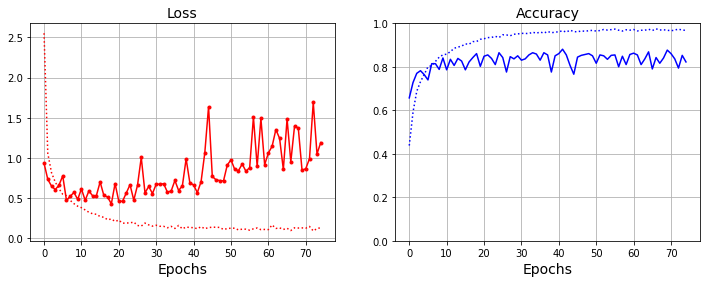

In [19]:
plot_results(small_model_history)

In [20]:
small_model_aug = get_small_model()
small_model_aug.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 75

small_model_aug_history = small_model_aug.fit(train_generator_aug,
                                      steps_per_epoch=train_generator_aug.samples/train_generator_aug.batch_size, 
                                      validation_data=test_generator_aug,
                                      epochs=epochs, batch_size=20, verbose=1)

Epoch 1/75
140/140 [==============================] - 54s 379ms/step - loss: 6.4426 - accuracy: 0.4003 - val_loss: 1.1923 - val_accuracy: 0.5444
Epoch 2/75
140/140 [==============================] - 53s 377ms/step - loss: 1.1060 - accuracy: 0.5899 - val_loss: 0.8952 - val_accuracy: 0.6694
Epoch 3/75
140/140 [==============================] - 54s 381ms/step - loss: 0.8589 - accuracy: 0.6705 - val_loss: 0.7633 - val_accuracy: 0.7399
Epoch 4/75
140/140 [==============================] - 53s 378ms/step - loss: 0.7177 - accuracy: 0.7325 - val_loss: 0.7823 - val_accuracy: 0.6895
Epoch 5/75
140/140 [==============================] - 53s 378ms/step - loss: 0.6811 - accuracy: 0.7556 - val_loss: 0.7532 - val_accuracy: 0.7560
Epoch 6/75
140/140 [==============================] - 53s 379ms/step - loss: 0.6404 - accuracy: 0.7660 - val_loss: 0.5493 - val_accuracy: 0.7944
Epoch 7/75
140/140 [==============================] - 53s 378ms/step - loss: 0.6067 - accuracy: 0.7771 - val_loss: 0.5135 - val_ac

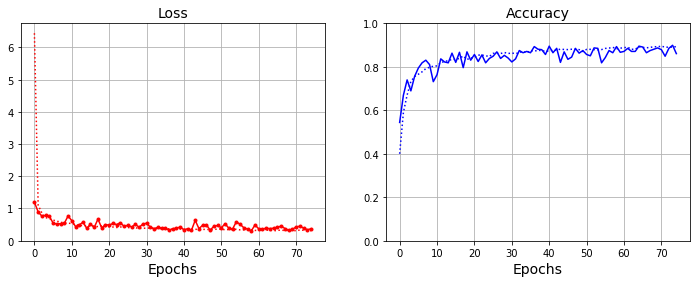

In [21]:
plot_results(small_model_aug_history)

In [22]:
big_model_aug = get_big_model()
big_model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 32)       

In [23]:
big_model_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 75

big_model_aug_history = big_model_aug.fit(train_generator_aug, steps_per_epoch=train_generator_aug.samples/train_generator_aug.batch_size, 
          validation_data=test_generator_aug,
          epochs=epochs, batch_size=20, verbose=1)

Epoch 1/75
140/140 [==============================] - 60s 415ms/step - loss: 1.5138 - accuracy: 0.3688 - val_loss: 1.5532 - val_accuracy: 0.4778
Epoch 2/75
140/140 [==============================] - 58s 412ms/step - loss: 1.0196 - accuracy: 0.5566 - val_loss: 1.0950 - val_accuracy: 0.7137
Epoch 3/75
140/140 [==============================] - 58s 410ms/step - loss: 0.7977 - accuracy: 0.6858 - val_loss: 0.8860 - val_accuracy: 0.7863
Epoch 4/75
140/140 [==============================] - 58s 409ms/step - loss: 0.7196 - accuracy: 0.7280 - val_loss: 1.0847 - val_accuracy: 0.7117
Epoch 5/75
140/140 [==============================] - 57s 408ms/step - loss: 0.6013 - accuracy: 0.7760 - val_loss: 0.8286 - val_accuracy: 0.8286
Epoch 6/75
140/140 [==============================] - 57s 407ms/step - loss: 0.5776 - accuracy: 0.7900 - val_loss: 0.8752 - val_accuracy: 0.7339
Epoch 7/75
140/140 [==============================] - 58s 413ms/step - loss: 0.6532 - accuracy: 0.7522 - val_loss: 1.0395 - val_ac

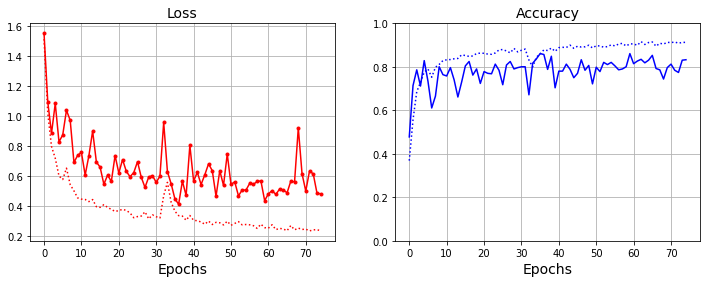

In [24]:
plot_results(big_model_aug_history)

# Part 2.1: Visualizing the results of our best model

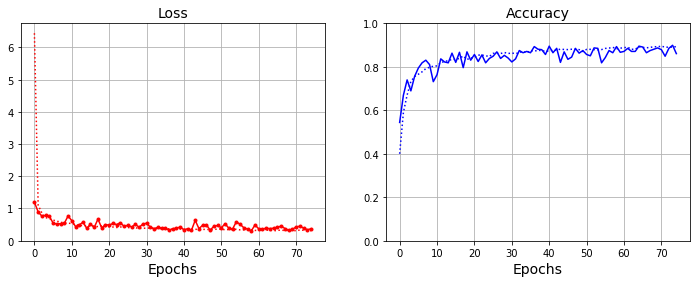

In [30]:
plot_results(small_model_aug_history)

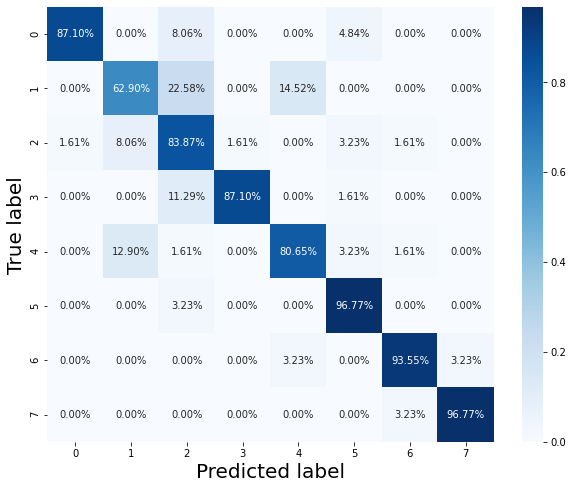

In [31]:
plot_confusion_matrix(small_model_aug,test_generator_aug)

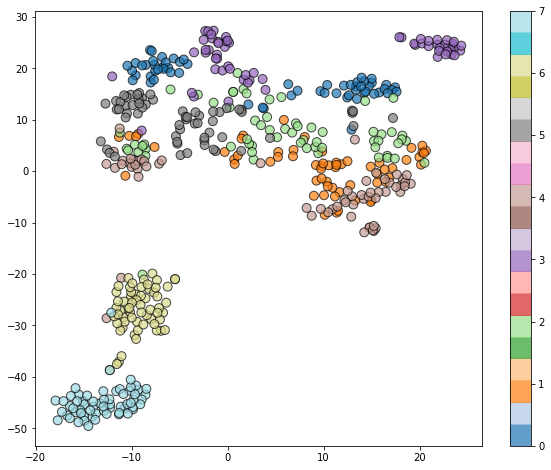

In [36]:
visualize_labelled_data(small_model_aug, test_generator_aug)

# Part 3: Image Segmentation

#### In this part we will use the trained model to classify small patches of a large image to help detect tumors
#### We will also show the probability of each cell to be tumorous

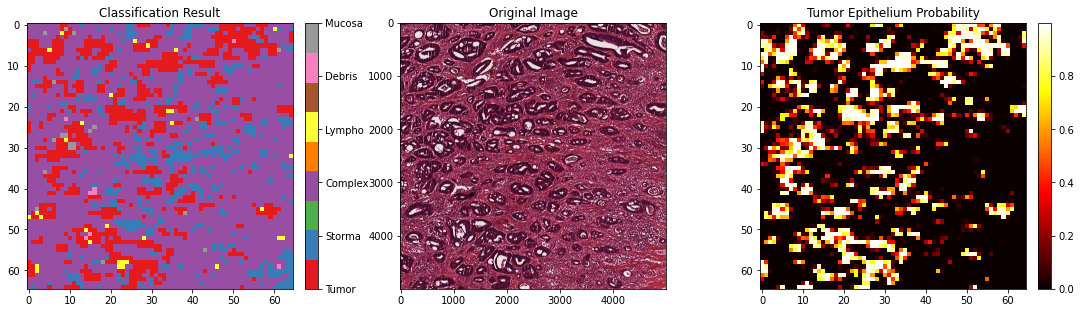

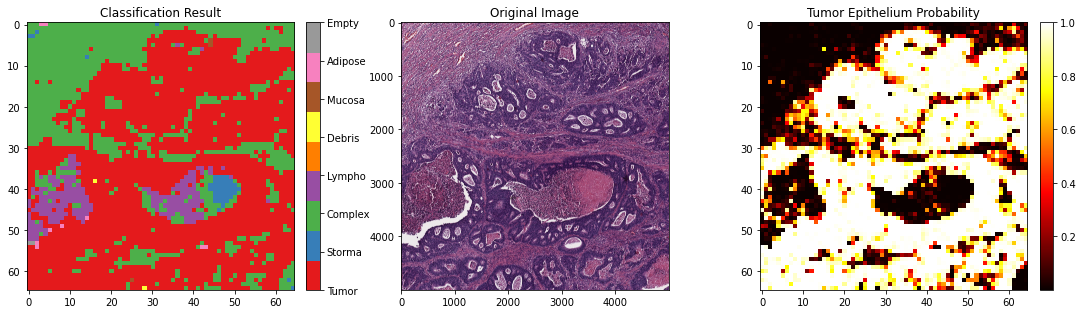

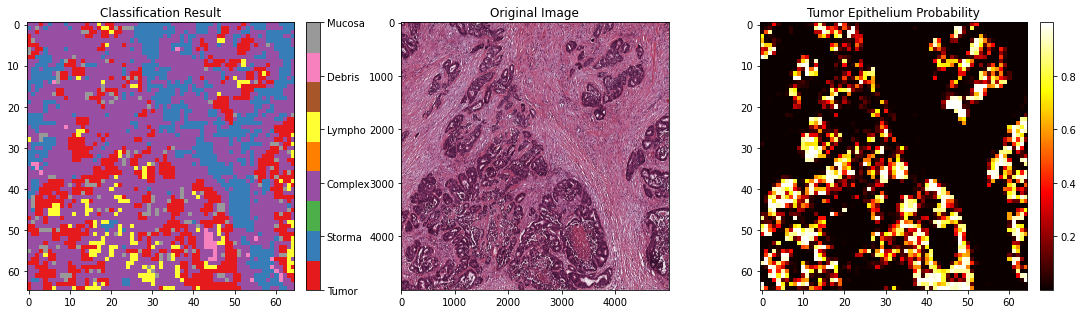

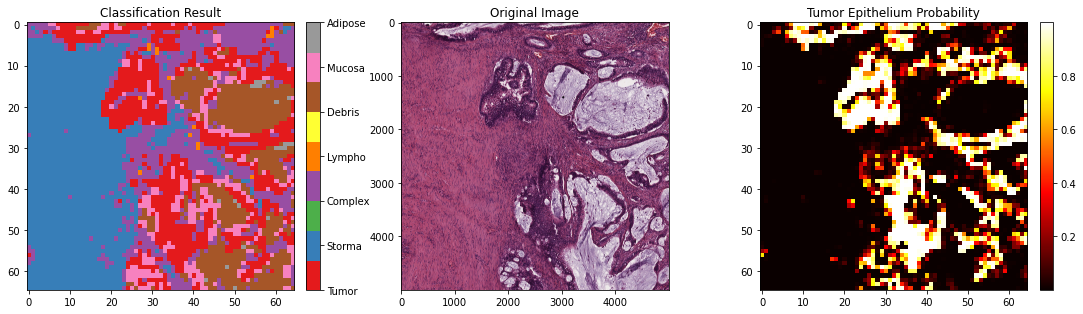

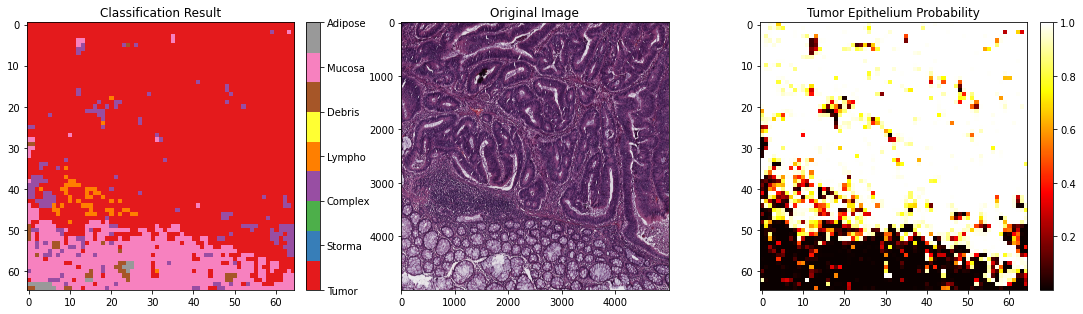

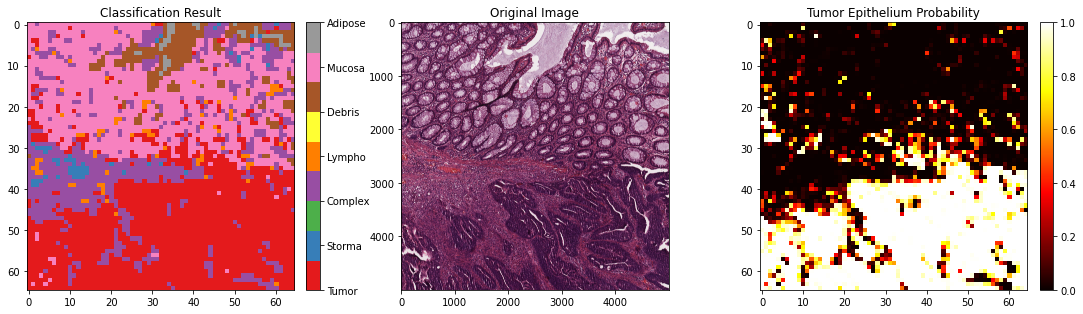

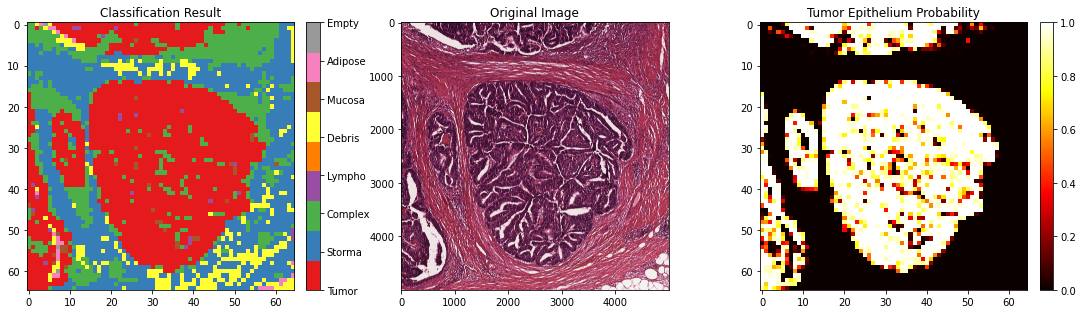

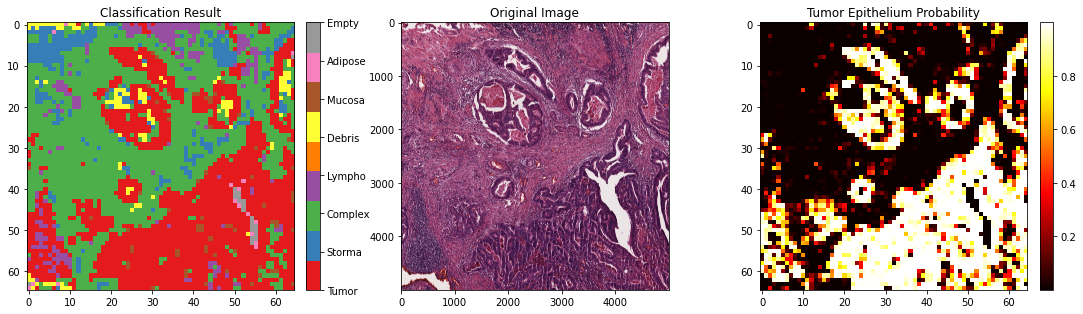

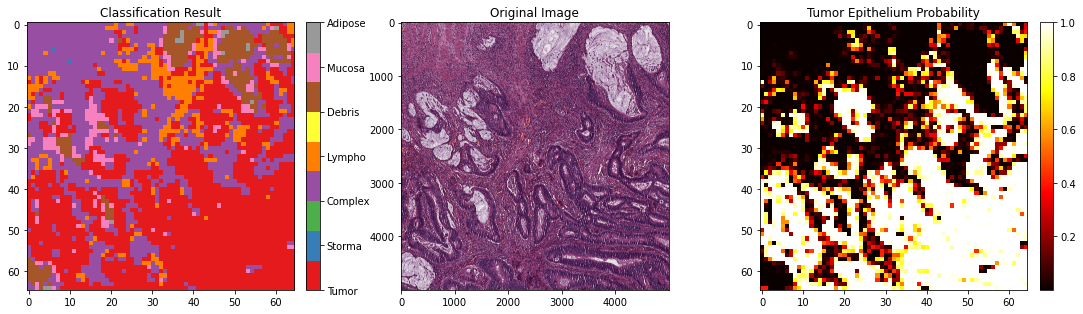

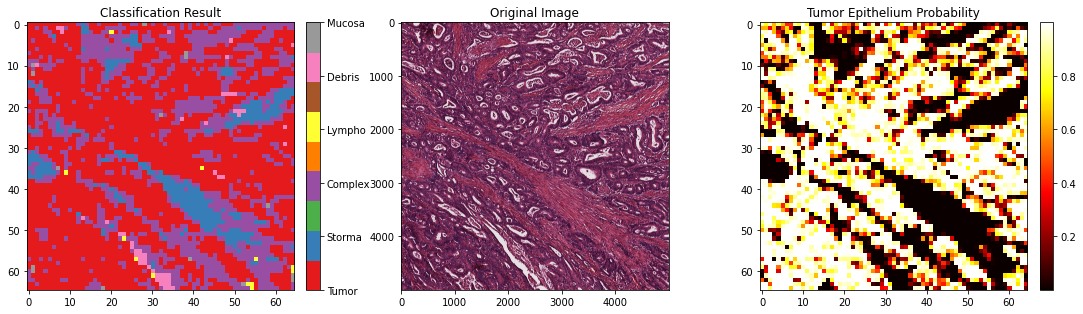

In [28]:
for x in range(1,11):
    
# IMPORTANT! choose to right path according (Colab or PC)

    #Colab section
    path = '/content/DeepLearningFinalProject/archive/Kather_texture_2016_larger_images_10/Kather_texture_2016_larger_images_10/CRC-Prim-HE-0'+str(x)+'_APPLICATION.tif'
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #End of Colab section

    #PC ection
#     path = 'archive\Kather_texture_2016_larger_images_10\Kather_texture_2016_larger_images_10\CRC-Prim-HE-0'+str(x)+'_APPLICATION.tif'
#     image = tiff.imread(path)
    #End of PC section

    patches = patchify(image, (150, 150, 3), step=75) #Split image to small patches
    patches_shape = patches.shape
    colored_patches = np.zeros((patches_shape[0],patches_shape[1])) #Create the label-colored image
    tumor_prob = np.zeros((patches_shape[0],patches_shape[1])) #Create the probability image
    
    for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                single_patch = patches[i,j]
                yhat = small_model_aug.predict(single_patch) 
                colored_patches[i,j] = np.argmax(yhat) #argmax returs the index with the highest score
                tumor_prob[i,j] = yhat[0,0] #[0,0]contains the probabilty for the patch to contain tumouros cells
    
    fig = plt.figure(figsize=(15, 45))
    plt.subplot(11,3,3*x-2)
    plt.title("Classification Result")
    plt.imshow(colored_patches,cmap='Set1')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_ticks([0,1,2,3,4,5,6,7])
    cbar.set_ticklabels(['Tumor', 'Storma','Complex','Lympho','Debris','Mucosa','Adipose','Empty'])

    plt.subplot(11,3,3*x-1)
    plt.title("Original Image")
    plt.imshow(image)

    plt.subplot(11,3,3*x)
    plt.title("Tumor Epithelium Probability")
    plt.imshow(tumor_prob,cmap='hot')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    
    fig.tight_layout()


# Part 4: Used Resources:



In [ ]:
# https://www.kaggle.com/kmader/colorectal-histology-mnist

# Various jupyter notebooks and lectures by Dr. Jonathan Rubin

# https://www.youtube.com/channel/UC34rW-HtPJulxr5wp2Xa04w/featured